In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [2]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def create_seq(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)
	
# split a univariate dataset into train/test sets
def split_dataset(data,steps):
	# split into standard weeks

	# restructure into windows of weekly data
	train = np.array(np.split(data, len(data)/steps))

	return train

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [3]:
root_dir = "./"

loc_2019_WEP = root_dir + "2019_full_data.csv"
loc_2020_WEP= root_dir + "2020_WEP_ONLY.csv"

#load dataset

df_2019=pd.read_csv(loc_2019_WEP, index_col=0, parse_dates=True, usecols=['DATE','WEP ($/MWh)'])
df_2020=pd.read_csv(loc_2020_WEP, index_col=0, parse_dates=True)

In [4]:
x = split_dataset(df_2019.values, 48)

In [5]:
data = x.reshape((x.shape[0]*x.shape[1],x.shape[2]))

In [6]:
train_x, train_y = to_supervised(x,336,48)

In [7]:
#train model
# prepare data
#train_x, train_y = to_supervised(train, n_input)
# define parameters
verbose, epochs, batch_size = 1, 1000, 42
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
model.save(root_dir + "model_LSTM_1000.h5")

Train on 17137 samples
Epoch 1/1000
17137/17137 [==============================] - 114s 7ms/sample - loss: 6064275610.5622
Epoch 2/1000
17137/17137 [==============================] - 112s 7ms/sample - loss: 12274.2980
Epoch 3/1000
17137/17137 [==============================] - 119s 7ms/sample - loss: 12270.4543
Epoch 4/1000
17137/17137 [==============================] - 143s 8ms/sample - loss: 12265.7279
Epoch 5/1000
17137/17137 [==============================] - 126s 7ms/sample - loss: 12260.1397
Epoch 6/1000
17137/17137 [==============================] - 124s 7ms/sample - loss: 12253.6336
Epoch 7/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 12246.1187
Epoch 8/1000
17137/17137 [==============================] - 112s 7ms/sample - loss: 12237.4295
Epoch 9/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 12227.5235
Epoch 10/1000
17137/17137 [==============================] - 114s 7ms/sample - loss: 12216.1442
Epoch 11/1000
17137/1

17137/17137 [==============================] - 139s 8ms/sample - loss: 7671.3839
Epoch 87/1000
17137/17137 [==============================] - 119s 7ms/sample - loss: 7614.7006
Epoch 88/1000
17137/17137 [==============================] - 134s 8ms/sample - loss: 7558.3547
Epoch 89/1000
17137/17137 [==============================] - 145s 8ms/sample - loss: 7502.3628
Epoch 90/1000
17137/17137 [==============================] - 115s 7ms/sample - loss: 7446.6963
Epoch 91/1000
17137/17137 [==============================] - 114s 7ms/sample - loss: 7391.3784
Epoch 92/1000
17137/17137 [==============================] - 115s 7ms/sample - loss: 7336.3399
Epoch 93/1000
17137/17137 [==============================] - 114s 7ms/sample - loss: 7281.6409
Epoch 94/1000
17137/17137 [==============================] - 114s 7ms/sample - loss: 7227.3176
Epoch 95/1000
17137/17137 [==============================] - 114s 7ms/sample - loss: 7173.3146
Epoch 96/1000
17137/17137 [==============================] - 114

17137/17137 [==============================] - 110s 6ms/sample - loss: 4028.5706
Epoch 172/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 3999.7250
Epoch 173/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 3971.2303
Epoch 174/1000
17137/17137 [==============================] - 111s 6ms/sample - loss: 3943.0492
Epoch 175/1000
17137/17137 [==============================] - 111s 6ms/sample - loss: 3915.1963
Epoch 176/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 3887.6949
Epoch 177/1000
17137/17137 [==============================] - 111s 6ms/sample - loss: 3860.4722
Epoch 178/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 3833.5913
Epoch 179/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 3807.0446
Epoch 180/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 3780.8450
Epoch 181/1000
17137/17137 [===========================

17137/17137 [==============================] - 113s 7ms/sample - loss: 2696.7253
Epoch 257/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2693.1762
Epoch 258/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2689.8130
Epoch 259/1000
17137/17137 [==============================] - 114s 7ms/sample - loss: 2686.6074
Epoch 260/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2683.5657
Epoch 261/1000
17137/17137 [==============================] - 119s 7ms/sample - loss: 2680.6655
Epoch 262/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2677.9846
Epoch 263/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2675.4565
Epoch 264/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2673.1251
Epoch 265/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2670.8927
Epoch 266/1000
17137/17137 [===========================

17137/17137 [==============================] - 114s 7ms/sample - loss: 2644.7084
Epoch 342/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.7064
Epoch 343/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.7046
Epoch 344/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.7030
Epoch 345/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.7042
Epoch 346/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.7008
Epoch 347/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.7010
Epoch 348/1000
17137/17137 [==============================] - 116s 7ms/sample - loss: 2644.7001
Epoch 349/1000
17137/17137 [==============================] - 116s 7ms/sample - loss: 2644.6987
Epoch 350/1000
17137/17137 [==============================] - 115s 7ms/sample - loss: 2644.6980
Epoch 351/1000
17137/17137 [===========================

17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6926
Epoch 427/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6918
Epoch 428/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6926
Epoch 429/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6913
Epoch 430/1000
17137/17137 [==============================] - 111s 6ms/sample - loss: 2644.6921
Epoch 431/1000
17137/17137 [==============================] - 111s 6ms/sample - loss: 2644.6906
Epoch 432/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6915
Epoch 433/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6917
Epoch 434/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6920
Epoch 435/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6912
Epoch 436/1000
17137/17137 [===========================

17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6910
Epoch 512/1000
17137/17137 [==============================] - 111s 6ms/sample - loss: 2644.6923
Epoch 513/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6920
Epoch 514/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6914
Epoch 515/1000
17137/17137 [==============================] - 111s 6ms/sample - loss: 2644.6931
Epoch 516/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6928
Epoch 517/1000
17137/17137 [==============================] - 111s 6ms/sample - loss: 2644.6920
Epoch 518/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6925
Epoch 519/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6911
Epoch 520/1000
17137/17137 [==============================] - 111s 6ms/sample - loss: 2644.6917
Epoch 521/1000
17137/17137 [===========================

17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6922
Epoch 597/1000
17137/17137 [==============================] - 115s 7ms/sample - loss: 2644.6906
Epoch 598/1000
17137/17137 [==============================] - 111s 6ms/sample - loss: 2644.6912
Epoch 599/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6914
Epoch 600/1000
17137/17137 [==============================] - 111s 6ms/sample - loss: 2644.6917
Epoch 601/1000
17137/17137 [==============================] - 111s 7ms/sample - loss: 2644.6923
Epoch 602/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6927
Epoch 603/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6921
Epoch 604/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6920
Epoch 605/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6928
Epoch 606/1000
17137/17137 [===========================

17137/17137 [==============================] - 111s 6ms/sample - loss: 2644.6922
Epoch 682/1000
17137/17137 [==============================] - 111s 6ms/sample - loss: 2644.6915
Epoch 683/1000
17137/17137 [==============================] - 111s 6ms/sample - loss: 2644.6919
Epoch 684/1000
17137/17137 [==============================] - 111s 6ms/sample - loss: 2644.6913
Epoch 685/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6903
Epoch 686/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6916
Epoch 687/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6915
Epoch 688/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6909
Epoch 689/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6923
Epoch 690/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6918
Epoch 691/1000
17137/17137 [===========================

17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6914
Epoch 767/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6928
Epoch 768/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6925
Epoch 769/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6922
Epoch 770/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6937
Epoch 771/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6926
Epoch 772/1000
17137/17137 [==============================] - 111s 6ms/sample - loss: 2644.6931
Epoch 773/1000
17137/17137 [==============================] - 109s 6ms/sample - loss: 2644.6922
Epoch 774/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6921
Epoch 775/1000
17137/17137 [==============================] - 110s 6ms/sample - loss: 2644.6924
Epoch 776/1000
17137/17137 [===========================

17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.6916
Epoch 852/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.6917
Epoch 853/1000
17137/17137 [==============================] - 114s 7ms/sample - loss: 2644.6919
Epoch 854/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.6919
Epoch 855/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.6929
Epoch 856/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.6923
Epoch 857/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.6923
Epoch 858/1000
17137/17137 [==============================] - 114s 7ms/sample - loss: 2644.6915
Epoch 859/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.6911
Epoch 860/1000
17137/17137 [==============================] - 115s 7ms/sample - loss: 2644.6919
Epoch 861/1000
17137/17137 [===========================

17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.6921
Epoch 937/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.6908
Epoch 938/1000
17137/17137 [==============================] - 114s 7ms/sample - loss: 2644.6926
Epoch 939/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.6914
Epoch 940/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.6931
Epoch 941/1000
17137/17137 [==============================] - 114s 7ms/sample - loss: 2644.6915
Epoch 942/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.6917
Epoch 943/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.6916
Epoch 944/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.6919
Epoch 945/1000
17137/17137 [==============================] - 113s 7ms/sample - loss: 2644.6920
Epoch 946/1000
17137/17137 [===========================

In [11]:
#forecasting

test = split_dataset(df_2020.values, 48)
test_x, test_y = to_supervised(test,336,1)

In [12]:
asd = model.predict(test_x[20].reshape((1,len(test_x[1]),1)))

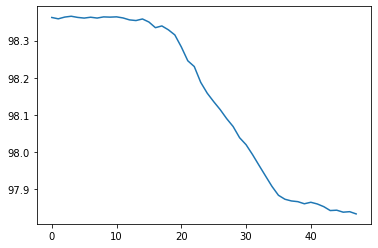

In [17]:
plt.plot(asd[0])
#plt.plot(test_y)
#plt.plot(test_x)


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 48)                4848      
Total params: 186,548
Trainable params: 186,548
Non-trainable params: 0
_________________________________________________________________
